In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
mnist = input_data.read_data_sets("MNIST_data/")
trX, trY, teX, teY = mnist.train.images, mnist.train.labels, mnist.test.images, mnist.test.labels

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
class StackedAutoEncoder(object):
    def __init__(self, list1, eta = 0.02):
        """
        list1: [input_dimension, hidden_layer_1, ....,hidden_layer_n]
        """
        N = len(list1)-1
        self._m = list1[0]
        self.learning_rate = eta
        
        # Create the Computational graph
        self._W = {}
        self._b = {}
        self._X = {}
        self._X['0'] = tf.placeholder('float', [None, list1[0]])
        
        for i in range(N):
            layer = '{0}'.format(i+1)
            print('AutoEncoder Layer {0}: {1} --> {2}'.format(layer, list1[i], list1[i+1]))
            self._W['E' + layer] = tf.Variable(tf.random_normal(shape=(list1[i], list1[i+1])),name='WtsEncoder'+layer)
            self._b['E'+ layer] = tf.Variable(np.zeros(list1[i+1]).astype(np.float32),name='BiasEncoder'+layer)
            self._X[layer] = tf.placeholder('float', [None, list1[i+1]])
            self._W['D' + layer] = tf.transpose(self._W['E' + layer])    # Shared weights
            self._b['D' + layer] = tf.Variable(np.zeros(list1[i]).astype(np.float32),name='BiasDecoder' + layer)
            
        
        
        # Placeholder for inputs
        self._X_noisy = tf.placeholder('float', [None, self._m])
        
        self.train_ops = {}
        self.out = {}
           
                              
        for i in range(N):
            layer = '{0}'.format(i+1)
            prev_layer = '{0}'.format(i)
            opt = self.pretrain(self._X[prev_layer], layer)
            self.train_ops[layer] = opt
            self.out[layer] = self.one_pass(self._X[prev_layer], self._W['E'+layer], self._b['E'+layer], self._b['D'+layer])
            
             
        self.y = self.encoder(self._X_noisy,N)    #Encoder output 
              
        self.r = self.decoder(self.y,N)  # Decoder ouput
        
        
        optimizer = tf.train.AdamOptimizer(self.learning_rate)           
        error = self._X['0'] - self.r  # Reconstruction Error
        
        self._loss = tf.reduce_mean(tf.pow(error, 2))
        self._opt = optimizer.minimize(self._loss)
        
        
                                               
    def encoder(self, X, N):
        x = X
        for i in range(N):
            layer = '{0}'.format(i+1)
            hiddenE = tf.nn.sigmoid(tf.matmul(x, self._W['E'+layer]) + self._b['E'+layer])
            x = hiddenE
        return x
            
        
    def decoder(self, X, N):
        x = X
        for i in range(N,0,-1):
            layer = '{0}'.format(i)
            hiddenD = tf.nn.sigmoid(tf.matmul(x, self._W['D'+layer]) + self._b['D'+layer])
            x = hiddenD
        return x
    
       
            
    def set_session(self, session):
        self.session = session
        
    def reconstruct(self,x, n_layers):
        h = self.encoder(x, n_layers)
        r = self.decoder(h, n_layers)
        return self.session.run(r, feed_dict={self._X['0']: x})
    
    def pretrain(self, X, layer ):
        y = tf.nn.sigmoid(tf.matmul(X, self._W['E'+layer]) + self._b['E'+layer])
        r =tf.nn.sigmoid(tf.matmul(y, self._W['D'+layer]) + self._b['D'+layer])
        
        # Objective Function
        error = X - r  # Reconstruction Error
        
        loss = tf.reduce_mean(tf.pow(error, 2))
        opt = tf.train.AdamOptimizer(.001).minimize(loss, var_list = 
                                                       [self._W['E'+layer],self._b['E'+layer],self._b['D'+layer]])
              
        return opt
            
  
    def one_pass(self, X, W, b, c):
        h = tf.nn.sigmoid(tf.matmul(X, W) + b)
        return h
    
   
    
        
        
    def fit(self, Xtrain, Xtr_noisy, layers, epochs = 1, batch_size = 100):
        N, D = Xtrain.shape
        num_batches = N // batch_size
        X_noisy = {}
        X = {}
        X_noisy ['0'] = Xtr_noisy
        X['0'] = Xtrain
        
        for i in range(layers):
            Xin = X[str(i)]
            print('Pretraining Layer ', i+1)
            for e in range(5):
                for j in range(num_batches):
                    batch = Xin[j * batch_size: (j * batch_size + batch_size)]
                    self.session.run(self.train_ops[str(i+1)], feed_dict= {self._X[str(i)]: batch})
            print('Pretraining Finished')
            X[str(i+1)] = self.session.run(self.out[str(i+1)], feed_dict = {self._X[str(i)]: Xin})
            
                
                    
        obj = []
        for i in range(epochs):
            for j in range(num_batches):
                batch = Xtrain[j * batch_size: (j * batch_size + batch_size)]
                batch_noisy = Xtr_noisy[j * batch_size: (j * batch_size + batch_size)]
                _, ob = self.session.run([self._opt,self._loss], feed_dict={self._X['0']: batch, self._X_noisy: batch_noisy})
                if j % 100 == 0 :
                    print('training epoch {0} batch {2} cost {1}'.format(i,ob, j)) 
                obj.append(ob)
        return obj

In [4]:
def corruption(x, noise_factor = 0.3): #corruption of the input
    noisy_imgs = x + noise_factor * np.random.randn(*x.shape)
    noisy_imgs = np.clip(noisy_imgs, 0., 1.)
    return noisy_imgs


In [5]:
Xtrain = trX.astype(np.float32)
Xtrain_noisy = corruption(Xtrain).astype(np.float32)
Xtest = teX.astype(np.float32)
Xtest_noisy = corruption(Xtest).astype(np.float32) 
_, m = Xtrain.shape

list1 = [m, 500, 50]   # List with number of neurons in Each hidden layer, starting from input layer
n_layers = len(list1)-1
autoEncoder = StackedAutoEncoder(list1)

#Initialize all variables
init = tf.global_variables_initializer()


    
with tf.Session() as sess:
    sess.run(init)
    autoEncoder.set_session(sess)
    err = autoEncoder.fit(Xtrain, Xtrain_noisy, n_layers, epochs=30)
    out = autoEncoder.reconstruct(Xtest_noisy[0:100],n_layers)

AutoEncoder Layer 1: 784 --> 500
AutoEncoder Layer 2: 500 --> 50
Pretraining Layer  1
Pretraining Finished
Pretraining Layer  2
Pretraining Finished
training epoch 0 batch 0 cost 0.10150674730539322
training epoch 0 batch 100 cost 0.0675622746348381
training epoch 0 batch 200 cost 0.06065288931131363
training epoch 0 batch 300 cost 0.0563741996884346
training epoch 0 batch 400 cost 0.055308450013399124
training epoch 0 batch 500 cost 0.05168097838759422
training epoch 1 batch 0 cost 0.052292823791503906
training epoch 1 batch 100 cost 0.04790482670068741
training epoch 1 batch 200 cost 0.04341510310769081
training epoch 1 batch 300 cost 0.04291597381234169
training epoch 1 batch 400 cost 0.04015181586146355
training epoch 1 batch 500 cost 0.03876486420631409
training epoch 2 batch 0 cost 0.039591532200574875
training epoch 2 batch 100 cost 0.03708085045218468
training epoch 2 batch 200 cost 0.03656088560819626
training epoch 2 batch 300 cost 0.03425168618559837
training epoch 2 batch 4

training epoch 25 batch 300 cost 0.018006179481744766
training epoch 25 batch 400 cost 0.016520751640200615
training epoch 25 batch 500 cost 0.01809670217335224
training epoch 26 batch 0 cost 0.017284439876675606
training epoch 26 batch 100 cost 0.01615685224533081
training epoch 26 batch 200 cost 0.016008973121643066
training epoch 26 batch 300 cost 0.016995172947645187
training epoch 26 batch 400 cost 0.016268093138933182
training epoch 26 batch 500 cost 0.017895421013236046
training epoch 27 batch 0 cost 0.017639130353927612
training epoch 27 batch 100 cost 0.016594262793660164
training epoch 27 batch 200 cost 0.016433008015155792
training epoch 27 batch 300 cost 0.016972912475466728
training epoch 27 batch 400 cost 0.01648031175136566
training epoch 27 batch 500 cost 0.018649550154805183
training epoch 28 batch 0 cost 0.0176535677164793
training epoch 28 batch 100 cost 0.015918292105197906
training epoch 28 batch 200 cost 0.017061598598957062
training epoch 28 batch 300 cost 0.0169

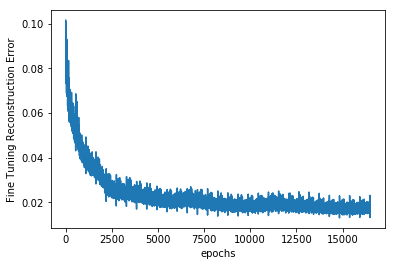

In [8]:
plt.plot(err)
plt.xlabel('epochs')
plt.ylabel('Fine Tuning Reconstruction Error')

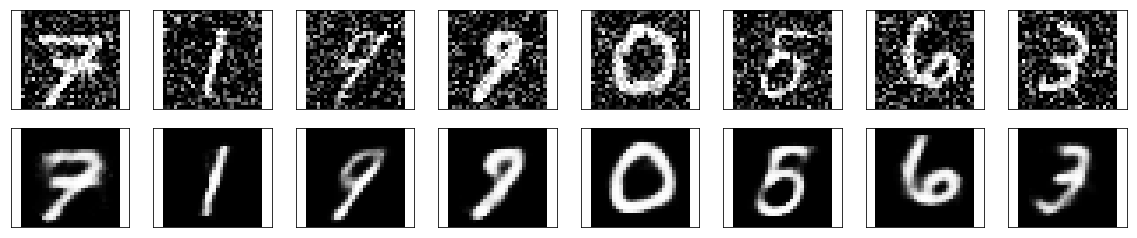

In [7]:
# Plotting original and reconstructed images
row, col = 2, 8
idx = np.random.randint(0, 100, row * col // 2)
f, axarr = plt.subplots(row, col, sharex=True, sharey=True, figsize=(20,4))
for fig, row in zip([Xtest_noisy,out], axarr):
    for i,ax in zip(idx,row):
        ax.imshow(fig[i].reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        